In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "Diffusion"

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image

import tensorflow as tf;
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ReduceLROnPlateau

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction

import pandas as pd
from sys import stdout
from datetime import datetime
import neptune as neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
import random
from DataMaker import HDF5ImageGenerator

2023-05-16 20:56:43.748584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 20:56:44.272046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/billyli/minic

In [3]:
%%capture
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2023-05-16 20:56:45.634955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 20:56:45.652907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 20:56:45.653108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
now = datetime.now()

DATASET_NAME = "HSC_v6"
MODEL_TYPE = "Diffusion"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/data3/Billy/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/data3/Billy/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/data3/Billy/Diffusion/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [5]:
channels = 5
BATCH_SIZE = 32

In [6]:
def preprocess(x, y):
    return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32))

def get_datasets():
    # Load the MNIST dataset
    train_ds = tfds.load('mnist', as_supervised=True, split="train")

    # Normalize to [-1, 1], shuffle and batch
    train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Return numpy arrays instead of TF tensors while iterating
    return tfds.as_numpy(train_ds)


dataset = get_datasets()

2023-05-16 20:56:46.198980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 9.77GiB (10485760000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-16 20:56:46.200785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 8.79GiB (9437184000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-16 20:56:46.202476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 7.91GiB (8493465600 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-16 20:56:46.204307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 7.12GiB (7644119040 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-16 20:56:46.206067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 6.41GiB (6879707136 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-16 20:56:46.207836: I

In [7]:
next(iter(dataset)).shape

2023-05-16 20:56:46.322112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-16 20:56:46.322469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-16 20:56:46.465242: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

(32, 32, 32, 1)

In [8]:
timesteps = 200

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[ : -1]), axis = 0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1 - alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size = x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape = [num], minval = 0, maxval = timesteps, dtype = tf.int32)

2023-05-16 20:52:00.964685: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


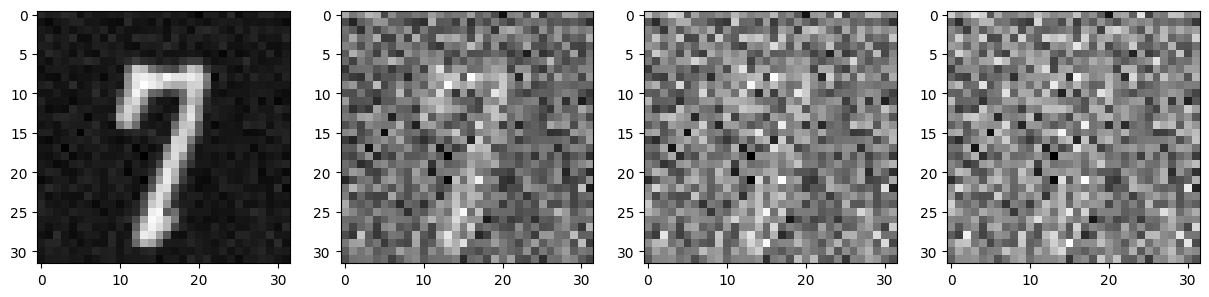

In [9]:
sample_mnist = next(iter(dataset))[0]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 100, 150, 199]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample_mnist, 0), np.array([i,]))
    plt.subplot(1, 4, index+1)
    plt.imshow(np.squeeze(np.squeeze(noisy_im, -1), 0), cmap='gray')
    

plt.show()

In [10]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions = 10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training = True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype = tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis = -1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training = True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training = True):
        return self.fn(x, training = training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters = dim, kernel_size = 4, strides = 2, padding = 'SAME')

def Downsample(dim):
    return nn.Conv2D(filters = dim, kernel_size = 4, strides = 2, padding = 'SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps = 1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training = True):
        var = tf.math.reduce_variance(x, axis = -1, keepdims = True)
        mean = tf.reduce_mean(x, axis = -1, keepdims = True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training = True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training = True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate = False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate = False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training = True):
        return gelu(x, self.approximate)

In [11]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups = 8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size = 3, strides = 1, padding = 'SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon = 1e-05)
        self.act = SiLU()


    def call(self, x, gamma_beta = None, training = True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim = None, groups = 8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units = dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups = groups)
        self.block2 = Block(dim_out, groups = groups)
        self.res_conv = nn.Conv2D(filters = dim_out, kernel_size = 1, strides = 1) if dim != dim_out else Identity()

    def call(self, x, time_emb = None, training = True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            gamma_beta = tf.split(time_emb, num_or_size_splits = 2, axis = -1)

        h = self.block1(x, gamma_beta = gamma_beta, training = training)
        h = self.block2(h, training = training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters = self.hidden_dim * 3, kernel_size = 1, strides = 1, use_bias = False)

        self.to_out = Sequential([
            nn.Conv2D(filters = dim, kernel_size = 1, strides = 1),
            LayerNorm(dim)
        ])

    def call(self, x, training = True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits = 3, axis = -1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h = self.heads), qkv)

        q = tf.nn.softmax(q, axis = -2)
        k = tf.nn.softmax(k, axis = -1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h = self.heads, x = h, y = w)
        out = self.to_out(out, training = training)

        return out

class Attention(Layer):
    def __init__(self, dim, heads = 4, dim_head = 127):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters = self.hidden_dim * 3, kernel_size = 1, strides = 1, use_bias = False)
        self.to_out = nn.Conv2D(filters = dim, kernel_size = 1, strides = 1)

    def call(self, x, training = True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits = 3, axis = -1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis = -1), axis = -1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis = -1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training = training)

        return out

In [12]:
class Unet(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=3,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True
                 ):
        super(Unet, self).__init__()
        
        # determine dimensions
        self.channels = channels
        
        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')
        
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        block_klass = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp
        
        self.time_mlp = Sequential([
            SinusoidalPosEmb(dim),
            nn.Dense(units=time_dim),
            GELU(),
            nn.Dense(units=time_dim)
        ], name="time embeddings")
        
        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)
        
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])
  
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])
        
        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)
        
        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")
        
    def call(self, x, time=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

In [13]:
# create our unet model
unet = Unet(channels=1)

# create our checkopint manager
ckpt = tf.train.Checkpoint(unet=unet)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=2)

# load from a previous checkpoint if it exists, else initialize the model from scratch
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

# initialize the model in the memory of our GPU
test_images = np.ones([1, 32, 32, 1])
test_timestamps = generate_timestamp(0, 1)
k = unet(test_images, test_timestamps)

# create our optimizer, we will use adam with a Learning rate of 1e-4
opt = keras.optimizers.Adam(learning_rate=1e-4)

Restored from ./checkpoints/ckpt-10


2023-05-16 20:52:02.319289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-16 20:52:02.797410: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-16 20:52:02.958109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
unet.summary()

Model: "unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  2100      
                                                                 
 time embeddings (Sequential  (1, 256)                 82432     
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  97088     
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 107008    
 )                                                               
                                                                 
 residual (Residual)         multiple                  33088     
                                                                 
 conv2d_8 (Conv2D)           multiple                  65600  

In [15]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [16]:
rng = 0

def train_step(batch):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, timestep_values)
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

In [10]:
iter(dataset)

<generator object _eager_dataset_iterator at 0x7f3264484eb0>

In [17]:
epochs = 10
for e in range(1, epochs+1):
    # this is cool utility in Tensorflow that will create a nice looking progress bar
    bar = tf.keras.utils.Progbar(len(dataset)-1)
    losses = []
    for i, batch in enumerate(iter(dataset)):
        # run the training loop
        loss = train_step(batch)
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])

    avg = np.mean(losses)
    print(f"Average loss for epoch {e}/{epochs}: {avg}")
    ckpt_manager.save(checkpoint_number=e)

2023-05-16 20:52:06.838512: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x892f5910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 20:52:06.838536: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-05-16 20:52:06.841899: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-16 20:52:06.899476: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-16 20:52:06.950118: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  44/1874 [..............................] - ETA: 12:38 - loss: 0.1105

2023-05-16 20:52:47.490759: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

In [ ]:
# Save a GIF using logged images
def save_gif(img_list, path="", interval=200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        im = (im + 1) * 127.5
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [ ]:

def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [ ]:
x = tf.random.normal((1,32,32,1))
img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0),-1))

for i in tqdm(range(timesteps-1)):
    t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
    pred_noise = unet(x, t)
    x = ddpm(x, pred_noise, t)
    img_list.append(np.squeeze(np.squeeze(x, 0),-1))

save_gif(img_list + ([img_list[-1]] * 100), "ddpm.gif", interval=20)

In [ ]:
def ddim(x_t, pred_noise, t, sigma_t):
    alpha_t_bar = np.take(alpha_bar, t)
    alpha_t_minus_one = np.take(alpha, t-1)

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one - (sigma_t ** 2)) ** 0.5) * pred_noise
    eps_t = np.random.normal(size=x_t.shape)
    pred = pred+(sigma_t * eps_t)

    return pred

In [ ]:
# Define number of inference loops to run
inference_timesteps = 10

# Create a range of inference steps that the output should be sampled at
inference_range = range(0, timesteps, timesteps // inference_timesteps)

x = tf.random.normal((1,32,32,1))
img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0),-1))

# Iterate over inference_timesteps
for index, i in tqdm(enumerate(reversed(range(inference_timesteps))), total=inference_timesteps):
    t = np.expand_dims(inference_range[i], 0)

    pred_noise = unet(x, t)

    x = ddim(x, pred_noise, t, 0)
    img_list.append(np.squeeze(np.squeeze(x, 0),-1))   

In [ ]:
# END